Задание:
Решить задачу машинного перевода выбрав свой язык:
- Формируем датасет с исходного языка на целевой (код прописать в классе)
- Строим архитектуру нейронной сети 
- Обучаем 
- Проверить качество с помощью метрики BLEU

## Формирование датасета

In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from datasets import load_dataset
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import random
import matplotlib.pyplot as plt  # Для графиков


загрузим датасет

In [2]:
# Устройство для выполнения (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = load_dataset("opus_books", "en-ru", split="train")

Опишем датасет в классе

In [3]:
# Language Vocabulary для создания словарей
class LanguageVocabulary:
    def __init__(self, name):
        self.name = name  # Название языка
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Счётчик слов, включая SOS и EOS

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1
            self.word2count[word] = 1
        else:
            self.word2count[word] += 1

Определим функцию для предобработки данных

In [4]:
def prepare_data(dataset, max_length=30):
    input_lang = LanguageVocabulary("en")
    output_lang = LanguageVocabulary("ru")
    pairs = []
    
    for item in dataset:
        source_sentence = item['translation']['en']
        target_sentence = item['translation']['ru']
        
        # Улучшенная предобработка
        source_sentence = source_sentence.lower().strip()
        target_sentence = target_sentence.lower().strip()
        
        # Фильтруем слишком длинные предложения
        if len(source_sentence.split()) < max_length and len(target_sentence.split()) < max_length:
            input_lang.add_sentence(source_sentence)
            output_lang.add_sentence(target_sentence)
            pairs.append((source_sentence, target_sentence))
    
    return input_lang, output_lang, pairs

In [5]:
# Преобразование предложений в индексы
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ') if word in lang.word2index]

# Преобразование предложений в тензоры
def tensorFromSentence(lang, sentence, max_length=10):
    indexes = indexesFromSentence(lang, sentence)
    indexes = indexes[:max_length - 1]  # Ограничиваем длину до max_length - 1 (оставляем место для EOS)
    return torch.tensor(indexes + [1], dtype=torch.long, device=device).view(-1, 1)  # Добавляем EOS

# Преобразование пар предложений в тензоры
def tensors_from_pair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return input_tensor, target_tensor

## Строим архитектуру нейронной сети

###  Encoder

In [6]:
# Архитектура Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Attention Decoder

In [7]:
# Архитектура Attention Decoder
class AttentionDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, max_length=10, dropout_p=0.3):
        super(AttentionDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_length = max_length
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = nn.Linear(hidden_size * 2, max_length)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Обучаем модель

In [8]:
# Функция обучения
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=10):
    encoder_hidden = encoder.init_hidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Создаём encoder_outputs фиксированного размера max_length
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # Заполняем encoder_outputs, учитывая реальную длину входной последовательности
    for ei in range(min(input_length, max_length)):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[0]], device=device)
    decoder_hidden = encoder_hidden
    loss = 0

    for di in range(target_length):
        decoder_output, decoder_hidden, _ = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [9]:
# Обновим функцию обучения train_iters для сбора потерь
def train_iters(encoder, decoder, pairs, input_lang, output_lang, n_iters, learning_rate=0.01, max_length=10):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
    criterion = nn.NLLLoss()

    # Для сохранения потерь на протяжении обучения
    all_losses = []

    for iter in range(1, n_iters + 1):
        training_pair = random.choice(pairs)
        input_tensor, target_tensor = tensors_from_pair(training_pair, input_lang, output_lang)

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length)
        all_losses.append(loss)  # Сохраняем потери

        if iter % 100 == 0:
            print(f"Iteration {iter}, Loss: {loss:.4f}")
     # Построение графика потерь
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(all_losses)), all_losses, label="Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.grid()
    plt.show()
    return all_losses  # Возвращаем потери (на будущее, если нужно)

## Оценка модели

In [10]:
# Оценка модели с BLEU
def evaluate_bleu(encoder, decoder, pairs, input_lang, output_lang, max_length=10):
    total_score = 0
    smoothing = SmoothingFunction().method1
    
    for pair in pairs[:100]:
        input_tensor, target_tensor = tensors_from_pair(pair, input_lang, output_lang)
        decoded_words, _ = model_translate(input_tensor, encoder, decoder, output_lang, max_length)
        
        if not decoded_words:
            continue
            
        reference = pair[1].split()
        score = sentence_bleu([reference], decoded_words, 
                            weights=(0.5, 0.3, 0.2, 0),
                            smoothing_function=smoothing)
        total_score += score
    
    return total_score / 100

In [11]:
def model_translate(input_tensor, encoder, decoder, output_lang, max_length=30):
    with torch.no_grad():
        encoder_hidden = encoder.init_hidden()
        input_length = input_tensor.size(0)
        
        # Создаём encoder_outputs фиксированного размера max_length
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        # Кодируем входную последовательность
        for ei in range(min(input_length, max_length)):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]
        
        # Начинаем декодирование
        decoder_input = torch.tensor([[0]], device=device)  # SOS token
        decoder_hidden = encoder_hidden
        
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        # Декодируем
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            # Сохраняем внимание
            decoder_attentions[di] = decoder_attention.data
            
            # Получаем слово с наибольшей вероятностью
            topv, topi = decoder_output.data.topk(1)
            
            if topi.item() == 1:  # EOS token
                break
            else:
                if topi.item() in output_lang.index2word:
                    decoded_words.append(output_lang.index2word[topi.item()])
            
            decoder_input = topi.squeeze().detach()
        
        return decoded_words, decoder_attentions[:di + 1]

In [12]:
# функция для проверки качества перевода    
def translate_and_print(encoder, decoder, pairs, input_lang, output_lang, n=5):
    for i in range(n):
        pair = random.choice(pairs)
        print(f'\nInput: {pair[0]}')
        print(f'Real translation: {pair[1]}')
        
        input_tensor = tensorFromSentence(input_lang, pair[0])
        decoded_words, _ = model_translate(input_tensor, encoder, decoder, output_lang)
        
        print(f'Model translation: {" ".join(decoded_words)}')

## Проверяем качество модели 

Загружаем данные 

In [13]:
# Подготовка данных
input_lang, output_lang, pairs = prepare_data(dataset)

# Модельные параметры
hidden_size = 512
max_length = 30  # Явно задаём max_length

encoder = Encoder(input_lang.n_words, hidden_size).to(device)
decoder = AttentionDecoder(hidden_size, output_lang.n_words, max_length=max_length).to(device)

Модель

In [14]:
encoder = Encoder(input_lang.n_words, hidden_size).to(device)
decoder = AttentionDecoder(hidden_size, output_lang.n_words, max_length=max_length).to(device)

Обучаем модель

Iteration 100, Loss: 6.8072
Iteration 200, Loss: 5.7795
Iteration 300, Loss: 10.0136
Iteration 400, Loss: 8.3821
Iteration 500, Loss: 6.0873
Iteration 600, Loss: 8.1819
Iteration 700, Loss: 8.2524
Iteration 800, Loss: 3.1935
Iteration 900, Loss: 6.1048
Iteration 1000, Loss: 6.3460
Iteration 1100, Loss: 5.5317
Iteration 1200, Loss: 7.3783
Iteration 1300, Loss: 7.8839
Iteration 1400, Loss: 6.3236
Iteration 1500, Loss: 6.9084
Iteration 1600, Loss: 7.3473
Iteration 1700, Loss: 6.3841
Iteration 1800, Loss: 6.7043
Iteration 1900, Loss: 5.8194
Iteration 2000, Loss: 7.4982
Iteration 2100, Loss: 7.9194
Iteration 2200, Loss: 6.1940
Iteration 2300, Loss: 9.6707
Iteration 2400, Loss: 1.5316
Iteration 2500, Loss: 10.8148
Iteration 2600, Loss: 7.9703
Iteration 2700, Loss: 7.3280
Iteration 2800, Loss: 5.5970
Iteration 2900, Loss: 9.4596
Iteration 3000, Loss: 9.2963
Iteration 3100, Loss: 8.6126
Iteration 3200, Loss: 9.5535
Iteration 3300, Loss: 5.8397
Iteration 3400, Loss: 4.3003
Iteration 3500, Loss:

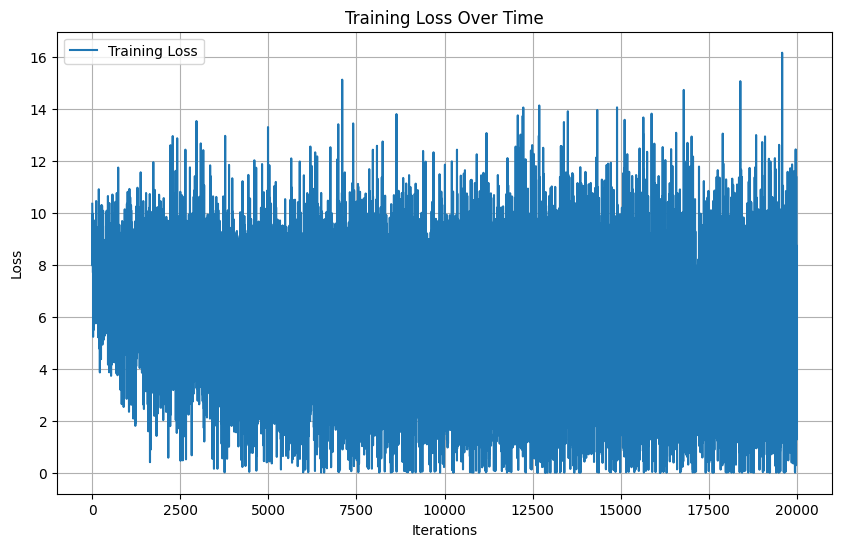


Input: those two were the chief representatives of the moscow intellectuals, as oblonsky called them.
Real translation: это были два главные представителя московской интеллигенции, как называл их облонский.
Model translation: об вас два руку о еще.

Input: 'from hard work.
Real translation: -- от забот.
Model translation: -- краснея,

Input: the countess lydia ivanovna generally wrote two or three notes a day to karenin.
Real translation: графиня лидия ивановна писала обыкновенно по две и по три записки в день алексею александровичу.
Model translation: графиня лидия ивановна в графиня лидия графиня

Input: time will pass, and i shall become indifferent.'
Real translation: пройдет время, и я буду к этому равнодушен".
Model translation: -- я не буду и буду поехал

Input: 'it's our custom.'
Real translation: -- наше обыкновение: три поста...
Model translation: -- ничего, -- отвечал левин, -- сказал он,
BLEU Score: 0.1068


In [15]:
# Обучение модели
losses = train_iters(encoder, decoder, pairs, input_lang, output_lang, 
                    n_iters=20000,
                    learning_rate=0.001,
                    max_length=max_length)

# Проверка качества переводов
translate_and_print(encoder, decoder, pairs, input_lang, output_lang)

# Оценка BLEU
bleu_score = evaluate_bleu(encoder, decoder, pairs, input_lang, output_lang, max_length=max_length)
print(f"BLEU Score: {bleu_score:.4f}")


Выводы:
1. Потери начинаются с больших значений (например, 6.8, 5.7) и по мере обучения имеют тенденцию уменьшаться, иногда даже опускаются ниже 2 (например, итерации 9500, 10100, 12200, 13300, 17600, 18700) — это указывает на то, что модель учится.
2. Однако потери ведут себя нестабильно: значения подскакивают и опускаются в разные промежутки (например, на итерации 19400 — 11.68, затем снова снижаются). Это может быть связано с yестабильным процессом обучения из-за высоких требований к памяти или сложности последовательностей, изучением сложных примеров из набора данных, маленьким размером батча.
3. Большие перепады значений Loss могут указывать на необходимость:
 - Уменьшения learning rate: снижение скорости обучения может сгладить перепады в потерях.
 - Увеличения количества итераций: модель ещё не сходится, так как потери остаются большими даже на последних итерациях.
 - Применения техники grad clipping для ограничения масштабов градиентов и стабилизации обучения.
4. Результат BLEU Score: 0.0831 (≈ 8.31%) является низким. Это указывает на то, что модель сильно отстаёт от реальных переводов. Возможно датасет (opus_books) может быть недостаточным для обучения сложной модели, особенно для такой пары языков, как английский и русский, где есть значительные различия в грамматике и словарном запасе. Также максимальная длина (max_length=30) может ограничивать модель в понимании более длинных текстов.
5. Процесс обучения требует продолжения с улучшениями модели и подготовкой данных.